# Modelo de clasificación usando buenas prácticas

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ymeza@ubiobio.cl

**Fecha de creación:** Noviembre de 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene la construcción de un modelo de clasificación usando `DecisionTreeClassifier` y considerando todas las buenas prácticas de la industria.

Utiliza un conjunto de datos de predicción de diabetes. Este conjunto de datos contiene una serie de parámetros fisiológicos de un paciente.

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.12. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```python
import pandas as pd
print(pd.__version__)
````

| Etapa | Herramienta      | Objetivo                                          |
| ----- | ---------------- | ------------------------------------------------- |
| 1     | train_test_split | separar train/test                                |
| 2     | Pipeline         | aplicar preprocesamiento + modelo                 |
| 3     | GridSearchCV     | buscar hiperparámetros usando CV dentro del train |
| 4     | best_estimator_  | obtener el mejor pipeline                         |
| 5     | fit final        | entrenar en TODO el train                         |
| 6     | score en test    | rendimiento real del modelo                       |


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score,  classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [ ]:
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=(0.05, 0.05)):
        self.limits = limits

    def fit(self, X, y=None):
        # Guardar nombres si es DataFrame, si no generar nombres genéricos
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
        else:
            self.columns_ = np.arange(X.shape[1])
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns_)
        for col in self.columns_:
            lower = X[col].quantile(self.limits[0])
            upper = X[col].quantile(1 - self.limits[1])
            X[col] = np.clip(X[col], lower, upper)
        return X.values

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.columns_)
        else:
            return np.array(input_features)

In [ ]:
!wget https://www.dropbox.com/s/lus9jhalh6j65qt/diabetes.csv

--2025-11-14 17:38:24--  https://www.dropbox.com/s/lus9jhalh6j65qt/diabetes.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/6ngpmrhofnz5fqf86efv5/diabetes.csv?rlkey=qndgwm5jvy70qf02wzlcbac11 [following]
--2025-11-14 17:38:25--  https://www.dropbox.com/scl/fi/6ngpmrhofnz5fqf86efv5/diabetes.csv?rlkey=qndgwm5jvy70qf02wzlcbac11
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucef3d00b8ac76f95aeba318df97.dl.dropboxusercontent.com/cd/0/inline/C1K7IdXSnlpKbW_mwSos44tR9BPtAKTW2LRDuInty1Dvom-zVDPKvhzX7vCgCt-Hz6vI5e49M-OL8GDsdNA9M9Zht1OA0QkTF9h4buNkAqdK-erB2Qv41LgwK8iOIZ1OlaPHg3PurBQE4mt7Jrt2vIO_/file# [following]
--2025-11-14 17:38:25--  https://ucef3d00b8ac76f95aeba318df97.dl.dropboxusercontent.com/cd/0/inline/C

In [ ]:
diabetes = pd.read_csv("diabetes.csv")

In [ ]:
features_num = np.array(diabetes.iloc[:,:-1].columns)
features_cat = [] # En este caso NO hay variables categóricas disponibles

# Preprocesamiento numérico: tratamiento atípicos  + imputación con media  + escalado estándar
numeric_transformer = Pipeline(steps=[
    ("winsorizer", Winsorizer()),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())])

# Preprocesamiento categórico: imputación + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))])

# Combina en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features_num),
        ("cat", categorical_transformer, features_cat)], remainder="drop")

pipeline_clasificacion = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier( # Instancia el árbol de decisión.
                  criterion = "entropy"
    ))
    ])

In [ ]:
diabetes_features = diabetes.iloc[:,:-1]
diabetes_label = diabetes.Outcome

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    diabetes_features,
    diabetes_label,
    test_size=0.2,
    random_state=29,
    stratify=diabetes_label
)

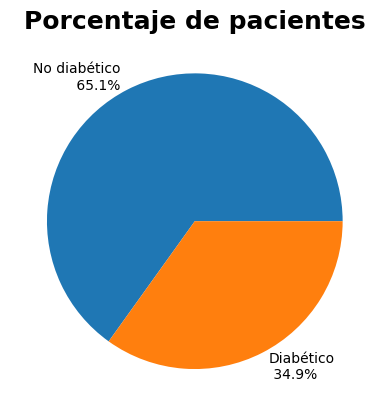

In [ ]:
# Gráfico de torta del porcentaje de pacientes
clases = np.array([diabetes[diabetes.Outcome == 0.0].shape[0],
                   diabetes[diabetes.Outcome == 1.0].shape[0]])

# Leyendas del gráfico.
labels = [ str(round(x * 1.0 / clases.sum() * 100.0, 2)) + '%'  for x in clases ]
labels[0] = 'No diabético\n ' + labels[0]
labels[1] = 'Diabético\n ' + labels[1]

plt.pie(clases, labels=labels)
plt.title('Porcentaje de pacientes', fontsize=18, fontweight="bold")
plt.show()

In [ ]:
param_grid = {
    "classifier__max_depth": range(1, 15),
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4]
}

In [ ]:
grid = GridSearchCV(
    estimator=pipeline_clasificacion,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('winsorizer',
                                                                                          Winsorizer()),
                                                                                         ('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         array(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype=object)),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         [])])),
                                       ('classifier',
                                        DecisionTreeClassifier(criterion='entropy'))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': range(1, 15),
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [ ]:
# Muestra los mejores parámetros
print("Mejores parámetros")
print("-"*20)
for indice, parametro in enumerate(grid.best_params_):
  print(f"Parámetro {indice+1} : {parametro :<30} = {grid.best_params_[parametro]}")

print("-"*20)
print(f"Mejor ROC-AUC en CV: {grid.best_score_ :.4f}")

Mejores parámetros
--------------------
Parámetro 1 : classifier__max_depth          = 4
Parámetro 2 : classifier__min_samples_leaf   = 4
Parámetro 3 : classifier__min_samples_split  = 10
--------------------
Mejor ROC-AUC en CV: 0.7860


In [ ]:
mejor_modelo = grid.best_estimator_
mejor_modelo

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  array(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype=object)),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=4,
                                        min_samples_leaf=4,
                                        min_samples_split=10))])

**Características de este modelo**
+ Incluye el mejor `max_depth`
+ Incluye el mejor `min_samples_split`
+ Incluye el mejor `min_samples_leaf`
+ Incluye el preprocesamiento con los parámetros correctos
+ Está listo para ser usado!!! ⭐

In [ ]:
# Ahora entrena el mejor modelo
mejor_modelo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  array(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype=object)),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=4,
                                        min_samples_leaf=4,
                                        min_samples_split=10))])

In [ ]:
y_pred_test = mejor_modelo.predict(X_test)
y_proba_test = mejor_modelo.predict_proba(X_test)[:, 1]

print(f"{'ROC-AUC en test' :<22}: {roc_auc_score(y_test, y_proba_test) :.3f}")
print(f"{'Accuracy en test' :<22}:{accuracy_score(y_test, y_pred_test): .3f}")

ROC-AUC en test       : 0.807
Accuracy en test      : 0.805


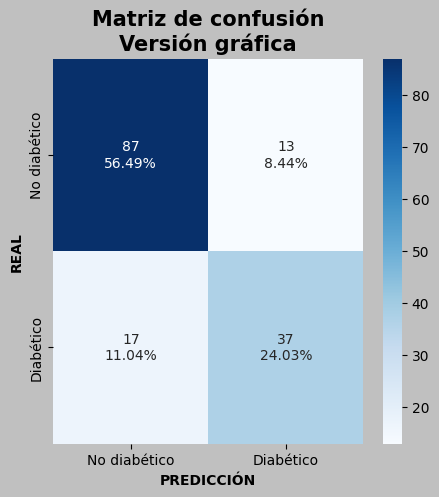

In [ ]:
# Matriz de confusión de forma gráfica
matriz = confusion_matrix(y_test, mejor_modelo.predict(X_test))
plt.figure(figsize=(5,5),facecolor= 'silver')
clases = ["No diabético","Diabético"]
group_counts = ["{0:0.0f}".format(value) for value in matriz.flatten()]
# Calcula porcentajes
group_percentages = ["{0:.2%}".format(value) for value in matriz.flatten()/matriz.sum()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
# Genera la gráfica
sns.heatmap(matriz, annot=labels, fmt='', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión\nVersión gráfica", fontsize=15, fontweight="bold")
plt.xlabel("PREDICCIÓN", fontsize=10, fontweight="bold")
plt.ylabel("REAL", fontsize=10, fontweight="bold")
plt.show()

In [ ]:
print(classification_report(
    y_test,
    mejor_modelo.predict(X_test), target_names=["No diabético","Diabético"]
))

              precision    recall  f1-score   support

No diabético       0.84      0.87      0.85       100
   Diabético       0.74      0.69      0.71        54

    accuracy                           0.81       154
   macro avg       0.79      0.78      0.78       154
weighted avg       0.80      0.81      0.80       154



# Revisión de `overfitting`

In [ ]:
train_pred = mejor_modelo.predict(X_train)
train_proba = mejor_modelo.predict_proba(X_train)[:, 1]

train_acc = accuracy_score(y_train, train_pred)
train_auc = roc_auc_score(y_train, train_proba)

print(f"{'Accuracy en entrenamiento' :<35} : {train_acc :.2f}")
print(f"{'AUC en entrenamiento' : <35} : {train_auc :.2f}")

Accuracy en entrenamiento           : 0.79
AUC en entrenamiento                : 0.85


In [ ]:
test_pred = mejor_modelo.predict(X_test)
test_proba = mejor_modelo.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, test_pred)
test_auc = roc_auc_score(y_test, test_proba)

print(f"{'Accuracy en test' :<25} : {test_acc :.2f}")
print(f"{'AUC en test' : <25} : {test_auc :.2f}")


Accuracy en test          : 0.81
AUC en test               : 0.81


In [ ]:
resumen = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Accuracy": [train_acc, test_acc],
    "AUC": [train_auc, test_auc]
}).round(4)

display(resumen)

,Dataset,Accuracy,AUC
0,Train,0.7866,0.8546
1,Test,0.8052,0.8075


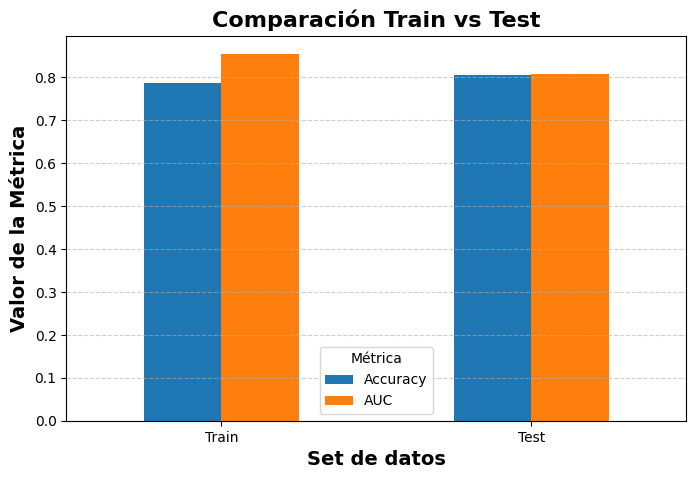

In [ ]:
plt.figure(figsize=(8,5))

ax = resumen.set_index("Dataset").plot(kind="bar", ax=plt.gca())
plt.title("Comparación Train vs Test", fontsize=16, fontweight="bold")
plt.ylabel("Valor de la Métrica", fontsize=14, fontweight="bold")
plt.xlabel("Set de datos", fontsize=14, fontweight="bold")
plt.xticks(rotation=0)
plt.legend(title="Métrica")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

| Situación                               | Interpretación  |
| --------------------------------------- | --------------- |
| **Train muy alto, Test mucho más bajo** | Overfitting     |
| **Train y Test similares y buenos**     | Modelo correcto |
| **Train y Test similares pero bajos**   | Underfitting    |


+ Si Accuracy_train >> Accuracy_test entonces **probable overfitting o sobreajuste**.

+ Si AUC_train >> AUC_test entonces **aún más claro el sobreajuste**.

+ Si las métricas están cercanas entonces **modelo logra generalizar bien**.